# Configuración de la GPU

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Preparación de los Directorios

In [2]:
import os

ferDirectory = os.path.join(os.getcwd(), 'FER-2013')
trainDirectory = os.path.join(ferDirectory, 'train')
testDirectory = os.path.join(ferDirectory, 'test')

print(f"FER directory:          {ferDirectory}")
print(f"FER train directory:    {trainDirectory}")
print(f"FER test directory:     {testDirectory}")

FER directory:          C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\FER-2013
FER train directory:    C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\FER-2013\train
FER test directory:     C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\FER-2013\test


# Modelos sin Augmentación de Datos

In [39]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(trainDirectory,
                                                                image_size=(48, 48),
                                                                batch_size=32,
                                                                seed=200,
                                                                validation_split=.2,
                                                                label_mode='categorical',
                                                                subset="training",
                                                                color_mode="grayscale")

validData = tf.keras.preprocessing.image_dataset_from_directory(trainDirectory,
                                                                image_size=(48, 48),
                                                                batch_size=32,
                                                                seed=200,
                                                                validation_split=.2,
                                                                label_mode='categorical',
                                                                subset="validation",
                                                                color_mode="grayscale")

testData = tf.keras.preprocessing.image_dataset_from_directory(testDirectory,
                                                              image_size=(48, 48),
                                                              batch_size=32,
                                                              label_mode='categorical',
                                                              color_mode="grayscale")

labelNames = trainData.class_names

normalization = tf.keras.layers.Rescaling(1./255)
trainData = trainData.map(lambda x, y: (normalization(x), y))
validData = validData.map(lambda x, y: (normalization(x), y))
testData = testData.map(lambda x, y: (normalization(x), y))

print(labelNames)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


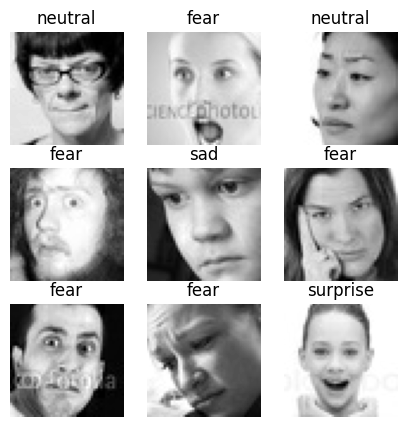

In [40]:
# Visualización de algunos datos del dataset
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in testData.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[np.argmax(labels[i])])
    plt.imshow(images[i], cmap="gray")

In [5]:
#Creación de 2 versiones de modelos CNN para data con Augmentación
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), strides=1, padding="same", activation='elu', input_shape=(48, 48, 1)),
  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.3),
    
  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(256, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='elu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

In [6]:
# Compilación de los nuevos modelos
modeloCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import TensorBoard

In [6]:
#Cargar la extension de tensorboard de colab
%load_ext tensorboard

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
with tf.device('/gpu:0'):
    modeloCNN.fit(trainData,
                  validation_data=validData,
                  epochs=60,
                  callbacks=[tensorboardCNN])

# Modelos con Augmentación de Datos

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
batchSize = 64

trainDataGen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.05,
                                  height_shift_range=0.05,
                                  shear_range=5,
                                  zoom_range=[1.0, 1.3],
                                  horizontal_flip=True,
                                  validation_split=0.2)

validDataGen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)

trainDataAug = trainDataGen.flow_from_directory(trainDirectory,
                                                target_size=(48,48),
                                                batch_size=batchSize,
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                shuffle=True,
                                                subset='training')

validDataAug = validDataGen.flow_from_directory(trainDirectory,
                                                target_size=(48,48),
                                                batch_size=batchSize,
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                shuffle=False,
                                                subset="validation")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


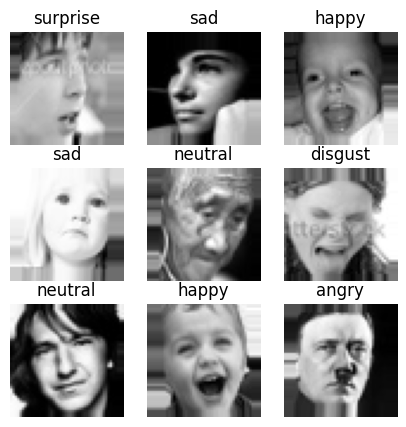

In [32]:
plt.figure(figsize=(5, 5))
images, labels = trainDataAug.__getitem__(1)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[int(np.argmax(labels[i]))])
    plt.imshow(images[i], cmap="gray")

In [36]:
#Creación de 2 versiones de modelos CNN para data con Augmentación
modeloAugCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64, (5,5), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(128, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [37]:
# Compilación de los nuevos modelos
modeloAugCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [38]:
tensorboardAugCNN = TensorBoard(log_dir='logs/cnnAug')
with tf.device('/gpu:0'):
    modeloAugCNN.fit(trainDataAug,
                     validation_data=validDataAug,
                     epochs=60,
                     batch_size=64,
                     steps_per_epoch=int(np.ceil(trainDataAug.n / float(64))),
                     validation_steps=int(np.ceil(validDataAug.n / float(64))),
                     callbacks=[tensorboardAugCNN])

Epoch 1/60
359/359 [==============================] - 13s 35ms/step - loss: 1.9136 - accuracy: 0.2746 - val_loss: 2.6387 - val_accuracy: 0.2513
Epoch 2/60
359/359 [==============================] - 13s 35ms/step - loss: 1.6064 - accuracy: 0.3691 - val_loss: 1.5765 - val_accuracy: 0.3964
Epoch 3/60
359/359 [==============================] - 12s 34ms/step - loss: 1.4987 - accuracy: 0.4191 - val_loss: 1.5564 - val_accuracy: 0.4135
Epoch 4/60
359/359 [==============================] - 12s 34ms/step - loss: 1.4179 - accuracy: 0.4566 - val_loss: 1.3383 - val_accuracy: 0.4767
Epoch 5/60
359/359 [==============================] - 13s 35ms/step - loss: 1.3590 - accuracy: 0.4767 - val_loss: 1.3143 - val_accuracy: 0.5048
Epoch 6/60
359/359 [==============================] - 12s 34ms/step - loss: 1.3094 - accuracy: 0.5014 - val_loss: 1.2501 - val_accuracy: 0.5243
Epoch 7/60
359/359 [==============================] - 13s 36ms/step - loss: 1.2788 - accuracy: 0.5176 - val_loss: 1.2832 - val_accuracy:

359/359 [==============================] - 12s 35ms/step - loss: 0.6608 - accuracy: 0.7609 - val_loss: 1.4063 - val_accuracy: 0.5849
Epoch 58/60
359/359 [==============================] - 12s 34ms/step - loss: 0.6440 - accuracy: 0.7620 - val_loss: 1.4338 - val_accuracy: 0.5926
Epoch 59/60
359/359 [==============================] - 12s 34ms/step - loss: 0.6298 - accuracy: 0.7675 - val_loss: 1.3812 - val_accuracy: 0.5978
Epoch 60/60
359/359 [==============================] - 12s 34ms/step - loss: 0.6335 - accuracy: 0.7675 - val_loss: 1.1921 - val_accuracy: 0.6121


In [43]:
modeloAugCNN.evaluate(testData)

225/225 [==============================] - 2s 7ms/step - loss: 1.1723 - accuracy: 0.6213


[1.1722859144210815, 0.6213430166244507]

# Visualización de Tensorboard

In [ ]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

# Guardado y Ejecución de Modelo TFLite

In [ ]:
# Crear una carpeta en caso se necesite
!mkdir saved_models

In [ ]:
# Guardar un modelo .h5
tf.keras.models.save_model(modeloAugCNN2, 'saved_models/modeloAugCNN2.h5')

In [ ]:
# Cargar un modelo .h5
model = tf.keras.models.load_model('saved_models/modeloAugCNN2.h5')

In [ ]:
# Convertir el modelo .h5 cargado a un modelo .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('saved_models/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import numpy as np

# Cargar una imagen de prueba para el modelo TFLite
image = tf.keras.utils.load_img("test_images/neutral.jpg",
                                color_mode="grayscale")
imgArray = tf.keras.utils.img_to_array(image)
imgArray = np.array([imgArray])  # Convertirlo a np.array para predicción en el modelo
imgArray /= 255.                 # Normalizar los valores de la imagen entre 0 y 1

In [ ]:
# Crear el interpretador del modelo y alocar los tensores
interpreter = tf.lite.Interpreter(model_path="saved_models/model.tflite")
interpreter.allocate_tensors()

# Obtener detalles del input y output del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preparar el tensor de entrada con la imagen, invokar el modelo y obtener el tensor de salida
interpreter.set_tensor(input_details[0]['index'], imgArray)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

In [ ]:
import matplotlib.pyplot as plt

imgArray = tf.keras.utils.img_to_array(image)
plt.figure(figsize=(1,1))
plt.imshow(imgArray, cmap="gray")
plt.title(labelNames[np.argmax(output[0])])
plt.axis("off")